# Packages

In [79]:
from nbd_util.units import Units, u, const
from nbd_util.profile import NFWProfile
from nbd_util.IC import EddInv
from nbd_util.IC import Jeans
from Gadget2.IC import IC_generator
from Gadget2.param import Gadget2Param


import scipy.integrate as integ
from sklearn.neighbors import KDTree
import os
import h5py
from myplt import *

In [2]:
# let M_vir = R_vir = G = 1 in that unit system
uL = 150.0 * u.kpc
uM = 10.0**12 * u.Msun
uV2 = const.G * uM / uL
uV = np.sqrt( uV2.to('cm^2/s^2').value ) * u.cm / u.s

units = Units()
units_nat = Units( uL.to('cm').value, uM.to('g').value, uV.to('cm/s').value )

units: L=3.085677581467192e+21 cm (1.0000000000000002 kpc), 
	M=1.9884754153381439e+43 g (10000000000.0 solMass), 
	V=100000.0 cm / s (1.0 km / s), 
	T=3.085677581467192e+16 s (0.9777922216731285 Gyr)
consts: G=43009.17270069976, Msun=9.999999999999999e-11
units: L=4.6285163722007875e+23 cm (150.0 kpc), 
	M=1.9884754153381437e+45 g (999999999999.9999 solMass), 
	V=16933039.24299076 cm / s (169.3303924299076 km / s), 
	T=2.7334232831927736e+16 s (0.8661695703072393 Gyr)
consts: G=0.9999999999999999, Msun=1e-12


In [3]:
units_nat['G']
nfw = NFWProfile( 1., 1./15., units=units_nat )

interp for M done, IM = [0.000000...1.801137]
interp for V done, IV = [0.000000...0.815079]


/work/yangyao/science/n-body/lib/nbd_util/profile.py:111: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Isigmays = [ integ.quad( f, y, self.yt )[0] for y in ys ]


interp for sigma done, Isigma = [4.691284...0.000000]


/work/yangyao/science/n-body/lib/nbd_util/profile.py:143: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  for IE in IEs ])


interp for fE done, xE = [-4.605170...-0.192276], xInt = [18.749071...-4.605170]


# Orbit

In [43]:
class OrbitSphericalPotential:
    def __init__(self, r_in, r_out, prof ):
        self.prof = prof
        self.G = prof.units['G']
        
        self._data = { 'r_in': r_in, 'r_out': r_out }
        self._get_E_L()
        self._get_Tr()
        self._get_Delta_phi()
    def __getitem__(self, key):
        return self._data[key]
        
    def _get_E_L(self):
        r1, r2 = self['r_in'], self['r_out']
        u1, u2 = 1./r1, 1./r2
        V1, V2 = self.prof.V(r1), self.prof.V(r2)
        L2 = 2.0*( V2-V1 )/(u1*u1 - u2*u2)
        L = np.sqrt(L2)
        E = u1*u1/2.0*L2 + V1
        self._data.update( {'L': L, 'E': E} )
        print('Orbit E=%g, L=%g'%(E, L))
    def _get_Tr(self):
        prof = self.prof
        E, L = self['E'], self['L']
        r1, r2 = self['r_in'], self['r_out']
        def f(r):
            V = prof.V(r)
            return 1. / np.sqrt( 2.0*(E-V) - L*L/(r*r) )
        Tr = 2.0*integ.quad( f, r1, r2 )[0]
        self._data['Tr'] = Tr
        print('\tTr=%g'%Tr)
    def _get_Delta_phi(self):
        prof = self.prof
        r1, r2 = self['r_in'], self['r_out']
        E, L = self['E'], self['L']
        def f(r):
            V = prof.V(r)
            return 1.0/ ( r*r*np.sqrt( 2.0*(E-V)-L*L/(r*r) ) )
        Delta_phi = integ.quad(f, r1, r2)[0] * 2.0* L
        self._data['Delta_phi'] = Delta_phi
        print('\tDelta_Phi=%g'%Delta_phi)
    def get_init_cond(self, pos='r_in'):
        if pos == 'r_out':
            r = self['r_out']
        elif pos == 'r_in':
            r = self['r_in']
        else:
            raise Exception('bad pos %s (must be r_in or r_out)'%pos)
        
        L = self['L'] 
        x = np.array([ r, 0., 0. ])
        v = np.array([ 0., L/r, 0. ])
        return x, v
    
    def _force(self, x):
        r = np.sqrt( np.sum( x*x ) )
        M = self.prof.M(r)
        return - self.G * M / (r*r*r) * x
    def _drift_kick_drift(self, x, v, h):
        x_mid = x + v * h/2.
        f_mid = self._force(x_mid)
        v_final = v + f_mid * h
        x_final = x_mid + v_final * h/2.
        return x_final, v_final
    def orbit(self, x, v, dt=1.0e-5, t=1.0, t_real=None, dt_real = None):
        h, t_lim = self['Tr'] * dt, self['Tr'] * t
        if t_real: t_lim = t_real
        if dt_real: h = dt_real
        time = 0.
        xs, vs, ts = [x], [v], [0.]
        while time < t_lim:
            new_x, new_v = self._drift_kick_drift( xs[-1], vs[-1], h )
            time += h
            xs.append(new_x)
            vs.append(new_v)
            ts.append( time )
        return np.array(xs), np.array(vs), np.array(ts)

## Check Implementation

In [160]:
r_in, r_out = nfw.r_at_M(np.array([.25, .5]))
orbit = OrbitSphericalPotential(r_in, r_out, nfw)

Orbit E=-1.22372, L=0.258896
	Tr=0.789459
	Delta_Phi=4.53351


In [161]:
x0, v0 = orbit.get_init_cond()
xs, vs, ts = orbit.orbit( x0, v0, t=6, dt=1.0e-5 )



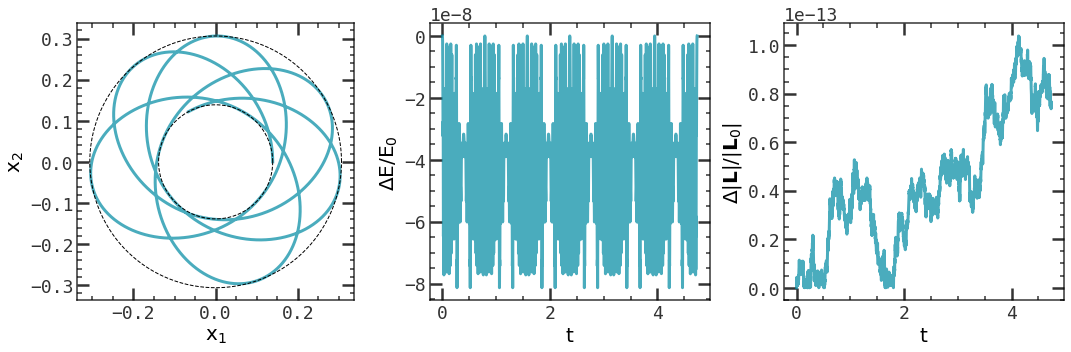

In [162]:
_, axs = m_get_figure((15,5), 1, 3)
axs = axs[0]

ax =axs[0]
x, y = xs[::100][:, :2].T
ax.plot(x,y,lw=3., c=mycms2[3])

phi = np.linspace(0., 2.0*np.pi, 256)
x,y = r_in*np.cos(phi), r_in*np.sin(phi)
ax.plot(x, y, ls='--', lw=1., c='k')

x,y = r_out*np.cos(phi), r_out*np.sin(phi)
ax.plot(x, y, ls='--', lw=1., c='k')
ax.set_aspect('equal')
m_set_label(ax, r'$\rm x_1$', r'$\rm x_2$')

x, y = xs[::100][:, :2].T
vx, vy = vs[::100][:, :2].T
t = ts[::100]
r = np.sqrt(x*x+y*y)
V = nfw.V(r)
v = np.sqrt(vx*vx+vy*vy)
T = 0.5*v*v
E = T+V
dE = np.abs(E - E[0]) / E[0]
L = np.cross(xs, vs)[::100]
L = np.sqrt(np.sum(L*L, axis=1))
dL = np.abs(L - L[0]) / L[0]
ax = axs[1]
ax.plot(t, dE, c=mycms2[3])
m_set_label(ax, r'$\rm t$', r'$\rm \Delta E/E_0$')
ax = axs[2]
ax.plot(t, dL, c=mycms2[3])
m_set_label(ax, r'$\rm t$', r'$\rm \Delta |{\bf L}|/|{\bf L}_0|$')

plt.tight_layout()
plt.savefig('../figs/orbit_leapfrog.pdf')
plt.savefig('../figs/orbit_leapfrog.png')
plt.show()

# Simulated Orbit in Gadget

In [132]:
eddinv = EddInv( nfw )
Nsample = 1000000
pos, vel, partmass = eddinv.samples(Nsample)

sampling rate =  0.32471623048617815
range: pos= 0.9928398569529009 , vel= 3.1963761872836334 , particle mass= 1e-06


In [329]:
jeans = Jeans( nfw )
Nsample = 1000000
pos, vel, partmass = jeans.get(Nsample)

range: pos= 0.9920019629847576 , vel= 4.262634525625957 , particle mass= 1e-06


## Generate ICs

In [45]:
m_encs = np.array([[.25, .5], [.22, .55], [.18, .6], [.15, .7], [.12, .8], [.1, .9]])
x0s, v0s = [], []
orbits = []

for m_enc in m_encs:
    r_in, r_out = nfw.r_at_M( m_enc )
    orbit = OrbitSphericalPotential(r_in, r_out, nfw)
    x0, v0 = orbit.get_init_cond(pos='r_out')
    
    x0s.append(x0)
    v0s.append(v0)
    orbits.append(orbit)
    
x0s = np.array(x0s)
v0s = np.array(v0s)

Orbit E=-1.22372, L=0.258896
	Tr=0.789459
	Delta_Phi=4.53351
Orbit E=-1.11568, L=0.249627
	Tr=0.851811
	Delta_Phi=4.49494
Orbit E=-1.01096, L=0.228444
	Tr=0.917982
	Delta_Phi=4.42279
Orbit E=-0.738731, L=0.215494
	Tr=1.139
	Delta_Phi=4.34866
Orbit E=-0.481876, L=0.195546
	Tr=1.4276
	Delta_Phi=4.2533
Orbit E=-0.241525, L=0.180431
	Tr=1.8101
	Delta_Phi=4.17272


In [331]:
n_trial = len(x0s)
n_samples = [ 5000, 10000, 50000, 100000, 500000, 1000000 ]
for n_sample in n_samples:
    x, v = np.array(pos[:n_sample]), np.array(vel[:n_sample])
    x[-n_trial:] = x0s
    v[-n_trial:] = v0s
    partmass = 1.0 / n_sample
    IC_generator( 'JeansICs/IC.n%d.hdf5'%(n_sample), x, v, partmass )

## Parameter Files

Change the number of particles

In [49]:
n_samples = [ 5000, 10000, 50000, 100000, 500000, 1000000 ]
for i, n_sample in enumerate(n_samples):
    dirname = 'chg_Npart_JeansICs/n%d'%n_sample
    os.system('mkdir -p %s'%dirname)
    os.system('mkdir -p %s/output'%dirname)
    
    pfile = Gadget2Param()
    pfile.set('InitCondFile', '../../JeansICs/IC.n%d'%n_sample)
    pfile.set('TimeMax', 20.0)
    pfile.set('TimeBetSnapshot', 0.1)
    
    eps_soft = (4./3 * np.pi / n_sample)**(1./3.) / 50.0
    pfile.set('SofteningHalo', eps_soft)
    
    pfile.set('UnitLength_in_cm', units_nat.uL.to('cm').value)
    pfile.set('UnitMass_in_g', units_nat.uM.to('g').value)
    pfile.set('UnitVelocity_in_cm_per_s', units_nat.uV.to('cm/s').value)
    
    pfile.set('PartAllocFactor', 5.0 if n_sample >= 50000 else 20.0)
    pfile.set('TreeAllocFactor', 4.0 if n_sample >= 50000 else 10.0)
    
    pfile.set('MaxSizeTimestep', 0.002)
    pfile.set('ErrTolForceAcc', 0.005)
    pfile.set('TreeDomainUpdateFrequency', 0.05)
    
    pfile.dump(dirname + '/param.txt')

Change the softening parameter

In [50]:
softs = [0.05, 0.1, 0.2, 0.5, 1., 2., 5., 10., 50., 100.]
n_sample = 100000
for i, soft in enumerate(softs):
    dirname = 'chg_soft/soft%.4f'%soft
    os.system('mkdir -p %s'%dirname)
    os.system('mkdir -p %s/output'%dirname)
    
    pfile = Gadget2Param()
    pfile.set('InitCondFile', '../../JeansICs/IC.n%d'%n_sample)
    pfile.set('TimeMax', 20.0)
    pfile.set('TimeBetSnapshot', 0.1)
    
    eps_soft = (4./3 * np.pi / n_sample)**(1./3.) / 50.0 * soft
    pfile.set('SofteningHalo', eps_soft)
    
    pfile.set('UnitLength_in_cm', units_nat.uL.to('cm').value)
    pfile.set('UnitMass_in_g', units_nat.uM.to('g').value)
    pfile.set('UnitVelocity_in_cm_per_s', units_nat.uV.to('cm/s').value)
    
    pfile.set('PartAllocFactor', 5.0 if n_sample >= 50000 else 20.0)
    pfile.set('TreeAllocFactor', 4.0 if n_sample >= 50000 else 10.0)
    
    pfile.set('MaxSizeTimestep', 0.002)
    pfile.set('ErrTolForceAcc', 0.005)
    pfile.set('TreeDomainUpdateFrequency', 0.05)
    
    pfile.dump(dirname + '/param.txt')

Change the time step criteria

In [51]:
dts = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
n_sample = 100000
for i, dt in enumerate(dts):
    dirname = 'chg_dt/dt%.4f'%dt
    os.system('mkdir -p %s'%dirname)
    os.system('mkdir -p %s/output'%dirname)
    
    pfile = Gadget2Param()
    pfile.set('InitCondFile', '../../JeansICs/IC.n%d'%n_sample)
    pfile.set('TimeMax', 20.0)
    pfile.set('TimeBetSnapshot', 0.1)
    
    eps_soft = (4./3 * np.pi / n_sample)**(1./3.) / 50.0
    pfile.set('SofteningHalo', eps_soft)
    
    pfile.set('UnitLength_in_cm', units_nat.uL.to('cm').value)
    pfile.set('UnitMass_in_g', units_nat.uM.to('g').value)
    pfile.set('UnitVelocity_in_cm_per_s', units_nat.uV.to('cm/s').value)
    
    pfile.set('PartAllocFactor', 5.0 if n_sample >= 50000 else 20.0)
    pfile.set('TreeAllocFactor', 4.0 if n_sample >= 50000 else 10.0)
    
    pfile.set('MaxSizeTimestep', 0.002*dt)
    pfile.set('ErrTolForceAcc', 0.005)
    pfile.set('TreeDomainUpdateFrequency', 0.05)
    
    pfile.dump(dirname + '/param.txt')

Change the opening criteria

In [52]:
alphas = [ 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0 ]
n_sample = 100000
for i, alpha in enumerate(alphas):
    dirname = 'chg_openAng/alpha%.4f'%alpha
    os.system('mkdir -p %s'%dirname)
    os.system('mkdir -p %s/output'%dirname)
    
    pfile = Gadget2Param()
    pfile.set('InitCondFile', '../../JeansICs/IC.n%d'%n_sample)
    pfile.set('TimeMax', 20.0)
    pfile.set('TimeBetSnapshot', 0.1)
    
    eps_soft = (4./3 * np.pi / n_sample)**(1./3.) / 50.0
    pfile.set('SofteningHalo', eps_soft)
    
    pfile.set('UnitLength_in_cm', units_nat.uL.to('cm').value)
    pfile.set('UnitMass_in_g', units_nat.uM.to('g').value)
    pfile.set('UnitVelocity_in_cm_per_s', units_nat.uV.to('cm/s').value)
    
    pfile.set('PartAllocFactor', 5.0 if n_sample >= 50000 else 20.0)
    pfile.set('TreeAllocFactor', 4.0 if n_sample >= 50000 else 10.0)
    
    pfile.set('MaxSizeTimestep', 0.002)
    pfile.set('ErrTolForceAcc', 0.005*alpha)
    pfile.set('TreeDomainUpdateFrequency', 0.05)
    
    pfile.dump(dirname + '/param.txt')

In [8]:
class OrbitLoader:
    def __init__(self, filebase, n_files, n_trial):
        self.n_trial = n_trial
        
        ds = []
        for i_file in range(n_files):
            filename = filebase + '_%0.3d.hdf5'%i_file
            ds.append( self._post_file(filename) )
        ts, xs, vs, Vs = [ np.array([ d[i] for d in ds ]) for i in (0,1,2,3) ]
        xs = [ xs[:, i, :] for i in range(self.n_trial) ]
        vs = [ vs[:, i, :] for i in range(self.n_trial) ]
        Vs = [ Vs[:, i] for i in range(self.n_trial) ]
        
        
        self._data = {'ts':ts, 'xs': xs, 'vs': vs, 'Vs': Vs}
    def __getitem__(self, key):
        return self._data[key]
    def _post_file(self, filename):
        f = h5py.File( filename, 'r' )
        self.n_sample = len( f['PartType1/ParticleIDs'] )
        ids = np.argsort( f['PartType1/ParticleIDs'][:] )[-self.n_trial:]
        
        t = f['Header'].attrs['Time']
        x = f['PartType1/Coordinates'][:][ids]
        v = f['PartType1/Velocities'][:][ids]
        V = f['PartType1/Potential'][:][ids]
        return t, x, v, V

In [9]:
class OrbitPostproc:
    def __init__(self, t, pos, vel, V):
        self.t, self.pos, self.vel, self.V = np.array(t), np.array(pos), \
            np.array(vel), np.array(V)
        
        r = np.linalg.norm(self.pos, axis=1)
        v = np.linalg.norm(self.vel, axis=1)
        self._data = { 'r': r, 'v': v }
        
        self._get_L_E()
        self._get_turning_points(k=3)
    def __getitem__(self, key):
        return self._data[key]
    def _get_L_E(self):
        L = np.cross( self.pos, self.vel )
        L_norm = np.linalg.norm( L, axis=1 )
        
        E = 0.5 * self['v'] * self['v'] + self.V
        self._data.update({'L': L, 'L_norm': L_norm, 'E':E})
    def _get_turning_points(self, k):
        r = self['r']
        is_max = np.ones(len(r)-2*k, dtype=bool)
        is_min = np.ones(len(r)-2*k, dtype=bool)
        for i in range(-k, k+1):
            is_max = is_max & (r[k:len(r)-k] >= r[k+i:len(r)-k+i])
            is_min = is_min & (r[k:len(r)-k] <= r[k+i:len(r)-k+i])
        ids_max = np.argwhere( is_max ).flat[:] + k
        ids_min = np.argwhere( is_min ).flat[:] + k
        r_max, r_min = r[ ids_max ], r[ ids_min ]
        t_max, t_min = self.t[ ids_max ], self.t[ ids_min ]
        self._data.update({'t_min': t_min, 't_max':t_max, 'r_max': r_max, 'r_min': r_min})

In [163]:
ol_real = []

for orbit in orbits:
    x0, v0 = orbit.get_init_cond( pos = 'r_out' )
    xs, vs, ts = orbit.orbit( x0, v0, t_real=20, dt=1.0e-4 )
    r = np.sqrt(np.sum(xs*xs, axis=1))
    Vs = nfw.V(r)
    ol_real.append( { 'xs':xs, 'vs':vs, 'ts':ts, 'Vs':Vs } )
    
op_real = [ OrbitPostproc( ol['ts'], ol['xs'], ol['vs'], ol['Vs'] ) for ol in ol_real ]
op_real = np.array(op_real)

In [164]:
ol_sim = []
n_samples = ( 5000, 10000, 50000, 100000, 500000, 1000000)
for n_sample in n_samples:
    ol = OrbitLoader('chg_Npart_JeansICs/n%d/output/snapshot'%n_sample, 90, 6)
    ol_sim.append( ol )

In [165]:
op_sim = [ [ OrbitPostproc( ol['ts'], ol['xs'][ip], ol['vs'][ip], ol['Vs'][ip] ) 
            for ip in range(6) ] for ol in ol_sim ]
op_sim = np.array(op_sim)
str_samples = [ '5000', r'10^4', r'5\times10^4', r'10^5', r'5\times10^5', r'10^6' ]

## Orbit

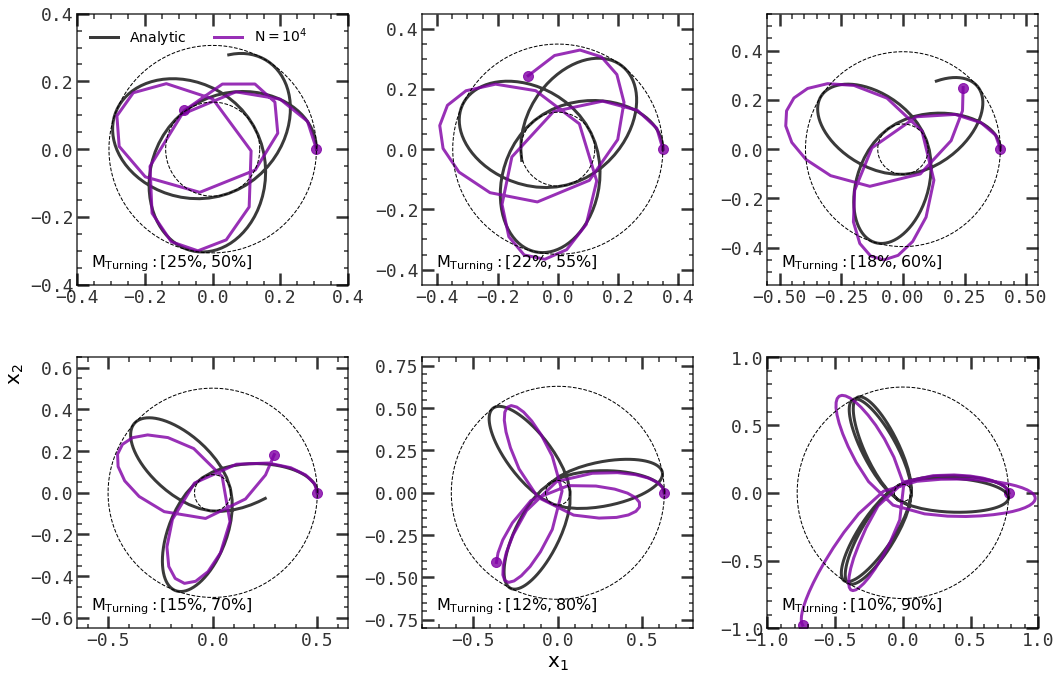

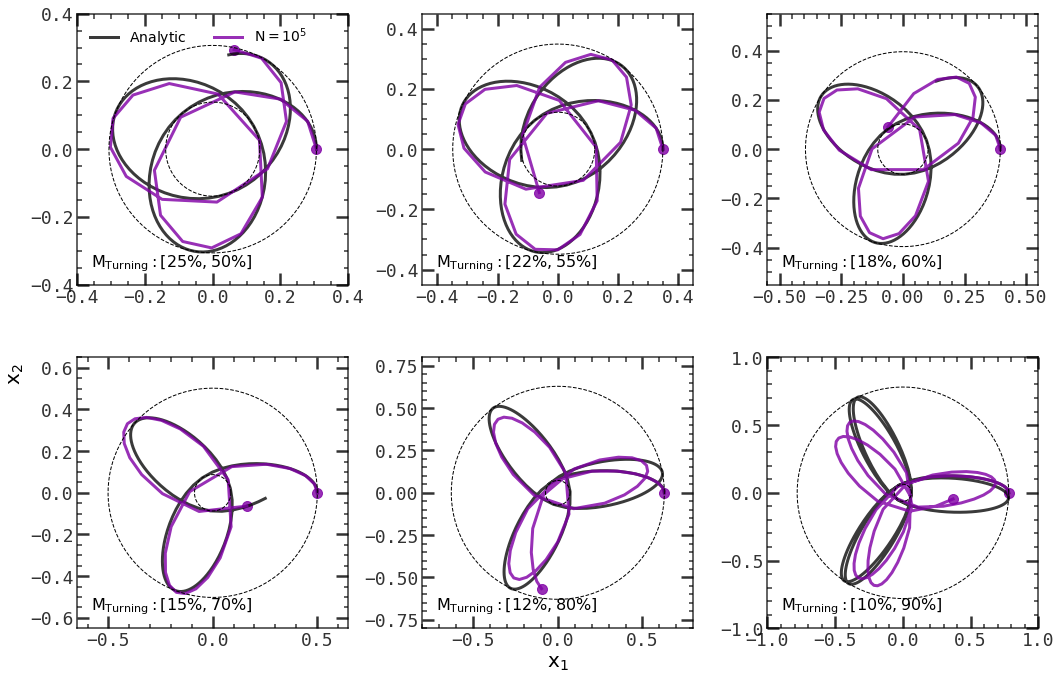

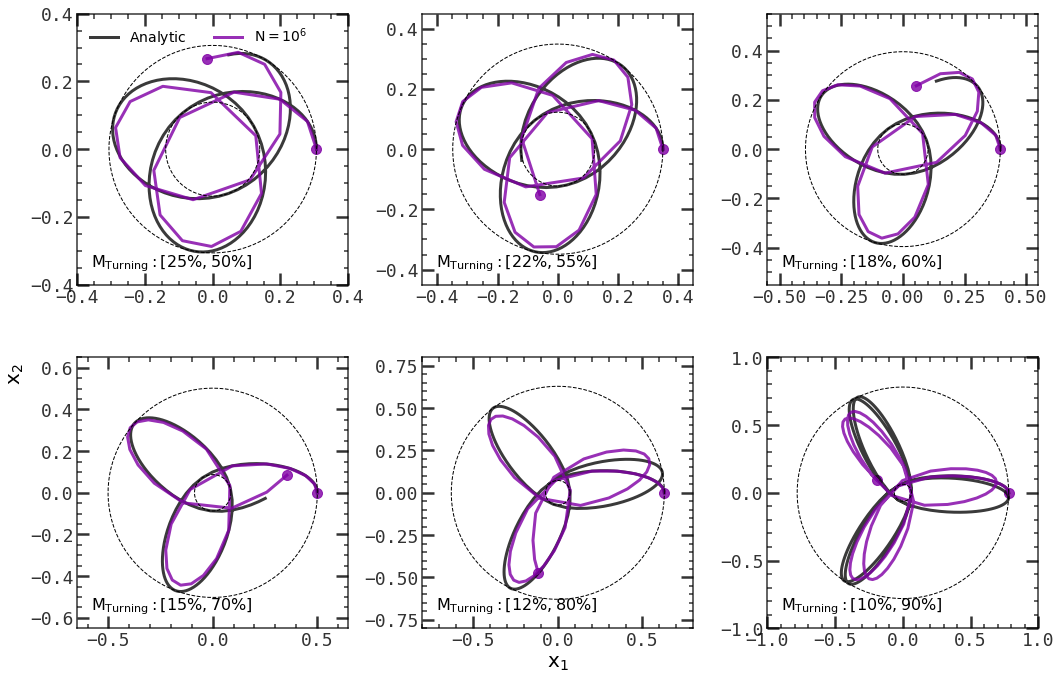

In [167]:
t_lims = [ 2.5, 3, 3, 3, 5, 10 ]
x_lims = [.40, .45, .55, .65, .8, 1.]

for iops in [1], [3], [5]:
    
    fig, axs = plt.subplots(2,3,figsize=(15,10) )
    axs = axs.flat
    for pid in range(6):
        ax = axs[pid]

        op = op_real[pid]
        x,y = op.pos[::200, :2].T
        t = op.t[::200]
        sel = t < t_lims[pid]
        ax.plot(x[sel], y[sel], c=mycms2[-1], lw=3., label=r'$\rm Analytic$')

        for j, iop in enumerate(iops):
            op = op_sim[iop][pid]
            x,y = op.pos[:, :2].T
            t = op.t
            sel = t < t_lims[pid]
            ax.plot(x[sel], y[sel], c=mycms2[2+j], lw=3., label=r'$\rm N=%s$'%(str_samples[iop]) )
            ax.scatter(x[sel][[0,-1]], y[sel][[0,-1]], color=mycms2[2+j], s=100)

        r_in, r_out = nfw.r_at_M( m_encs[pid] )
        phi = np.linspace(0., 2.0*np.pi, 200)
        x,y = r_in*np.cos(phi), r_in*np.sin(phi)
        ax.plot(x, y, c='k', ls='--', lw=1.)
        x,y = r_out*np.cos(phi), r_out*np.sin(phi)
        ax.plot(x, y, c='k', ls='--', lw=1.)
        
        ax.set_aspect('equal')
        x_lim = x_lims[pid]
        m_set_lim(ax, [-x_lim, x_lim], [-x_lim, x_lim])

        txpos(ax, r'$\rm M_{Turning}:[%.0f \%%, %.0f \%%]$'%( m_encs[pid][0]*100,  m_encs[pid][1]*100 ), 
            (.05, .08), 'k', 16)
        
    axs[0].legend(loc='upper left', frameon=False, fontsize=14, labelspacing=0, ncol=2)
    m_set_label(axs[3], y= ' '*20 + r'$\rm x_2$')
    m_set_label(axs[4], r'$\rm x_1$')
    
    plt.tight_layout()
    plt.savefig('../figs/chg_Npart_JeansICs_orbit%d.pdf'%iops[0])
    plt.savefig('../figs/chg_Npart_JeansICs_orbit%d.png'%iops[0])

    plt.show()

## Phase-space trajectory

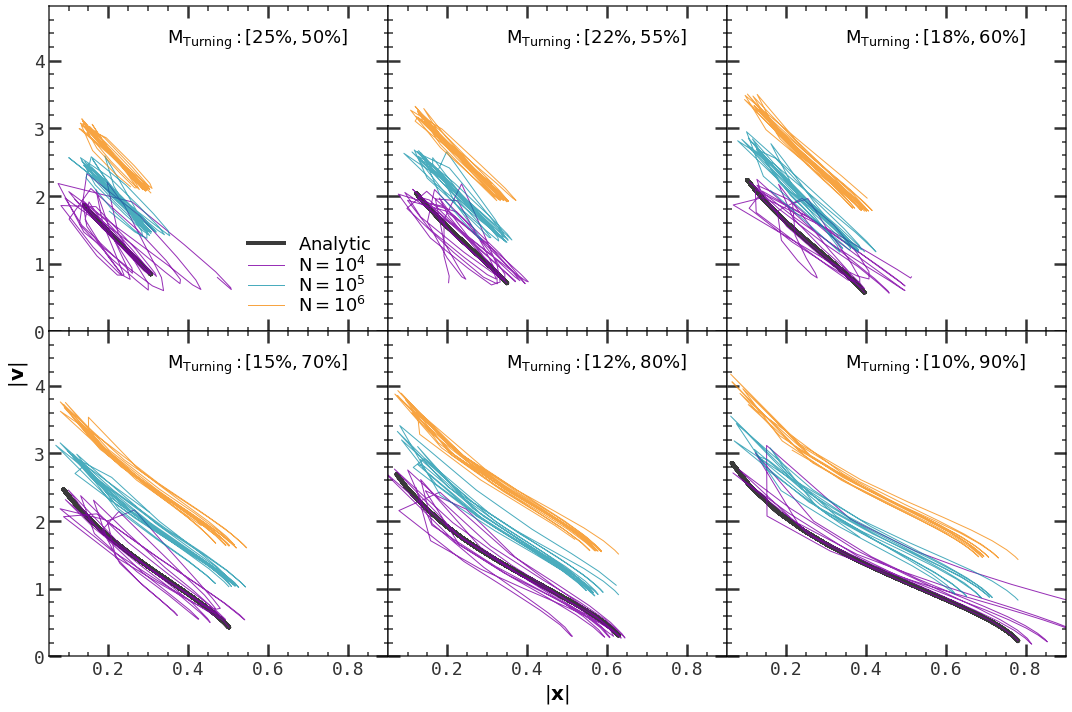

In [168]:
fig, axs = plt.subplots(2,3,figsize=(15,10), sharex = True, sharey=True, gridspec_kw={'hspace':0., 'wspace':0.})
axs = axs.flat

iops = [1,3,5]

for pid in range(6):
    ax = axs[pid]
    
    op = op_real[pid]
    ax.plot(op['r'][::200], op['v'][::200], c=mycms2[-1], lw=4., label=r'$\rm Analytic$')
    
    for j, iop in enumerate(iops):
        op = op_sim[iop][pid]
        ax.plot(op['r'], op['v']+j*.6, c=mycms2[2+j], lw=1., label=r'$\rm N=%s$'%( str_samples[iop] ))
    
    txpos(ax, r'$\rm M_{Turning}:[%.0f \%%, %.0f \%%]$'%( m_encs[pid][0]*100,  m_encs[pid][1]*100 ), 
            (.35, .9), 'k', 18)
    m_set_lim(ax, [0.05, .9], [0., 4.8])
    ax.label_outer()

axs[0].legend(loc='lower right', frameon=False, fontsize=18, labelspacing=0)
m_set_label(axs[3], y= ' '*20 + r'$\rm |{\bf v}|$')
m_set_label(axs[4], r'$\rm |{\bf x}|$')

plt.tight_layout()
plt.savefig('../figs/chg_Npart_JeansICs_phase.pdf')
plt.savefig('../figs/chg_Npart_JeansICs_phase.png')
plt.show()

## Turning Point

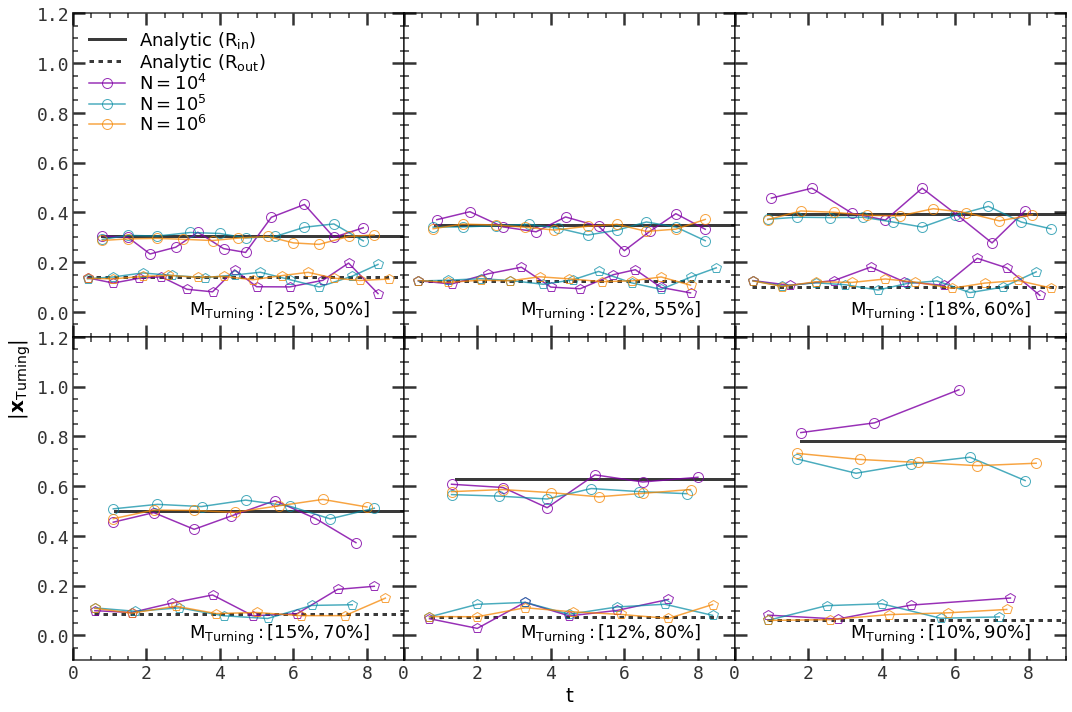

In [169]:
fig, axs = plt.subplots(2,3,figsize=(15,10), sharex = True, sharey=True, gridspec_kw={'hspace':0., 'wspace':0.})
axs = axs.flat

pfmt = dict(lw=1.5, markersize=10, markerfacecolor='none', markeredgewidth=1.)

iops = [1,3,5]
for pid in range(6):
    ax = axs[pid]
    
    op = op_real[pid]
    ax.plot(op['t_max'], op['r_max'], c=mycms2[-1], label=r'$\rm Analytic\ (R_{in})$', lw=3.)
    ax.plot(op['t_min'], op['r_min'], c=mycms2[-1], ls = (0,(1.5, 1.5)), label=r'$\rm Analytic\ (R_{out})$', 
            lw=3.)
    
    for j, iop in enumerate(iops):
        op = op_sim[iop][pid]
        x,y = op['t_max'], op['r_max']
        ax.plot(x, y, c=mycms2[2+j],**pfmt, marker='o', label=r'$\rm N=%s$'%( str_samples[iop] ))
        x,y = op['t_min'], op['r_min']
        ax.plot(x, y, c=mycms2[2+j],**pfmt, marker='p')
        
    txpos(ax, r'$\rm M_{Turning}:[%.0f \%%, %.0f \%%]$'%( m_encs[pid][0]*100,  m_encs[pid][1]*100 ), 
            (.35, .08), 'k', 18)
    m_set_lim(ax, [0., 9], [-.1, 1.2])
    ax.label_outer()

axs[0].legend(loc='upper left', frameon=False, fontsize=18, labelspacing=0)
m_set_label(axs[3], y= ' '*20 + r'$\rm |{\bf x}_{Turning}|$')
m_set_label(axs[4], r'$\rm t$')

plt.tight_layout()
plt.savefig('../figs/chg_Npart_JeansICs_turning.pdf')
plt.savefig('../figs/chg_Npart_JeansICs_turning.png')
plt.show()

## Angular Momentum

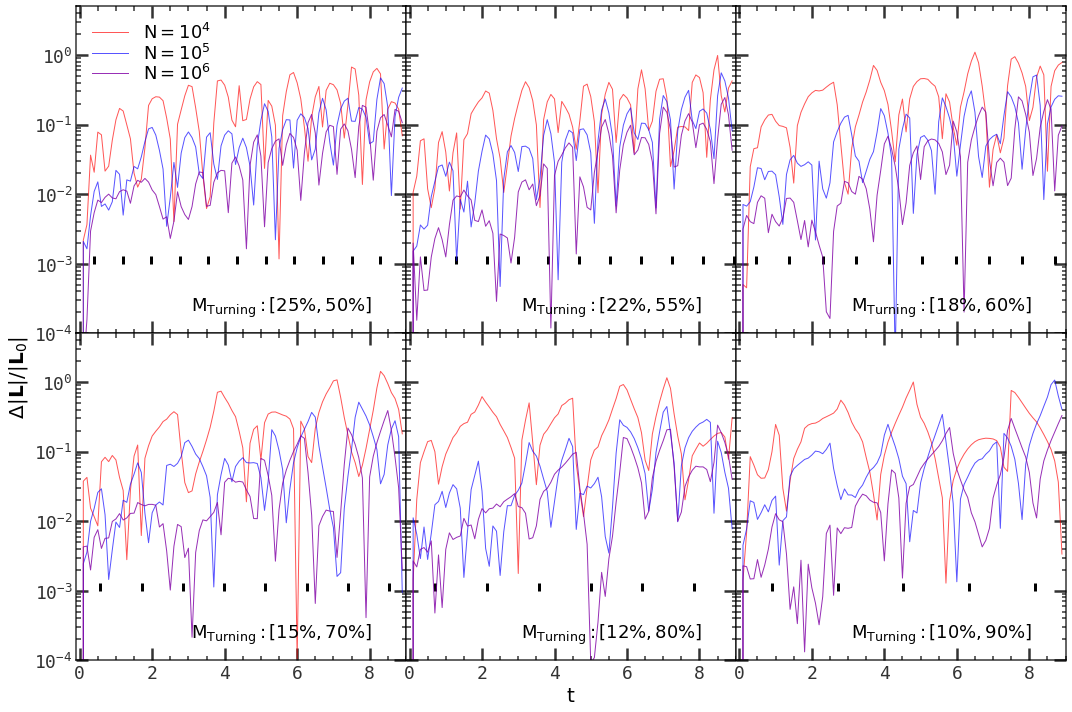

In [158]:
fig, axs = plt.subplots(2,3,figsize=(15,10), sharex = True, sharey=True, gridspec_kw={'hspace':0., 'wspace':0.})
axs = axs.flat

iops = [1,3,5]

for pid in range(6):
    ax = axs[pid]
    
    for j, iop in enumerate(iops):
        op = op_sim[iop][pid]
        L = op['L_norm']
        dL = np.abs(L-L[0]) / L[0]
        t = op.t
        ax.plot(t, dL, c=mycms2[j], lw=1.0, label=r'$\rm N=%s$'%( str_samples[iop] ))
        
    ax.vlines( orbits[pid]['Tr'] * np.arange(0.5,11, 1.0), 1.0e-3, 1.3e-3, color='k' )
    m_set_lim(ax, [-.1, 9], [1.0e-4, 5.0] )
    m_set_scale(ax, y='log')
    txpos(ax, r'$\rm M_{Turning}:[%.0f \%%, %.0f \%%]$'%( m_encs[pid][0]*100,  m_encs[pid][1]*100 ), 
        (.35, .08), 'k', 18)
    ax.label_outer()
    
    
axs[0].legend(loc='upper left', frameon=False, fontsize=18, labelspacing=0)
m_set_label(axs[3], y= ' '*20 + r'$\rm \Delta|{\bf L}|/|{\bf L}_0|$')
m_set_label(axs[4], r'$\rm t$')

plt.tight_layout()
plt.savefig('../figs/chg_Npart_JeansICs_L.pdf')
plt.savefig('../figs/chg_Npart_JeansICs_L.png')
plt.show()

## Energy

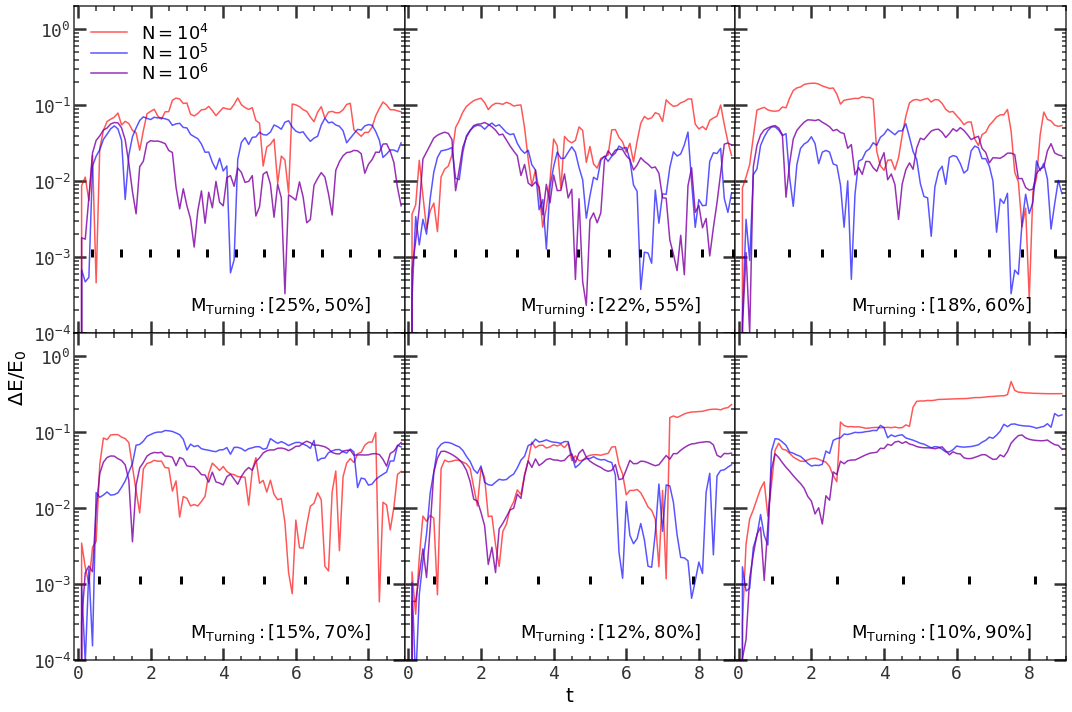

In [159]:
fig, axs = plt.subplots(2,3,figsize=(15,10), sharex = True, sharey=True, gridspec_kw={'hspace':0., 'wspace':0.})
axs = axs.flat

iops = [1,3,5]

for pid in range(6):
    ax = axs[pid]
    
    for j, iop in enumerate(iops):
        op = op_sim[iop][pid]
        E = op['E']
        dE = np.abs(E-E[0]) / np.abs(E[0])
        t = op.t
        ax.plot(t, dE, c=mycms2[j], lw=1.5, label=r'$\rm N=%s$'%( str_samples[iop] ))
        
    ax.vlines( orbits[pid]['Tr'] * np.arange(0.5,11, 1.0), 1.0e-3, 1.3e-3, color='k' )
    m_set_lim(ax, [-.1, 9], [1.0e-4, 2.0] )
    m_set_scale(ax, y='log')
    txpos(ax, r'$\rm M_{Turning}:[%.0f \%%, %.0f \%%]$'%( m_encs[pid][0]*100,  m_encs[pid][1]*100 ), 
        (.35, .08), 'k', 18)
    ax.label_outer()
    
axs[0].legend(loc='upper left', frameon=False, fontsize=18, labelspacing=0)
m_set_label(axs[3], y= ' '*20 + r'$\rm \Delta E/E_0$')
m_set_label(axs[4], r'$\rm t$')

plt.tight_layout()
plt.savefig('../figs/chg_Npart_JeansICs_E.pdf')
plt.savefig('../figs/chg_Npart_JeansICs_E.png')
plt.show()

## Change Softening

In [170]:
softs = [0.05, 0.1, 0.2, 0.5, 1., 2., 5., 10., 50., 100.]

In [171]:
ol_sim_softs = []
for soft in softs:
    ol = OrbitLoader('chg_soft/soft%.4f/output/snapshot'%soft, 33, 6)
    ol_sim_softs.append( ol )

In [172]:
op_sim_softs = [ [ OrbitPostproc( ol['ts'], ol['xs'][ip], ol['vs'][ip], ol['Vs'][ip] ) 
            for ip in range(6) ] for ol in ol_sim_softs ]
op_sim_softs = np.array(op_sim_softs)

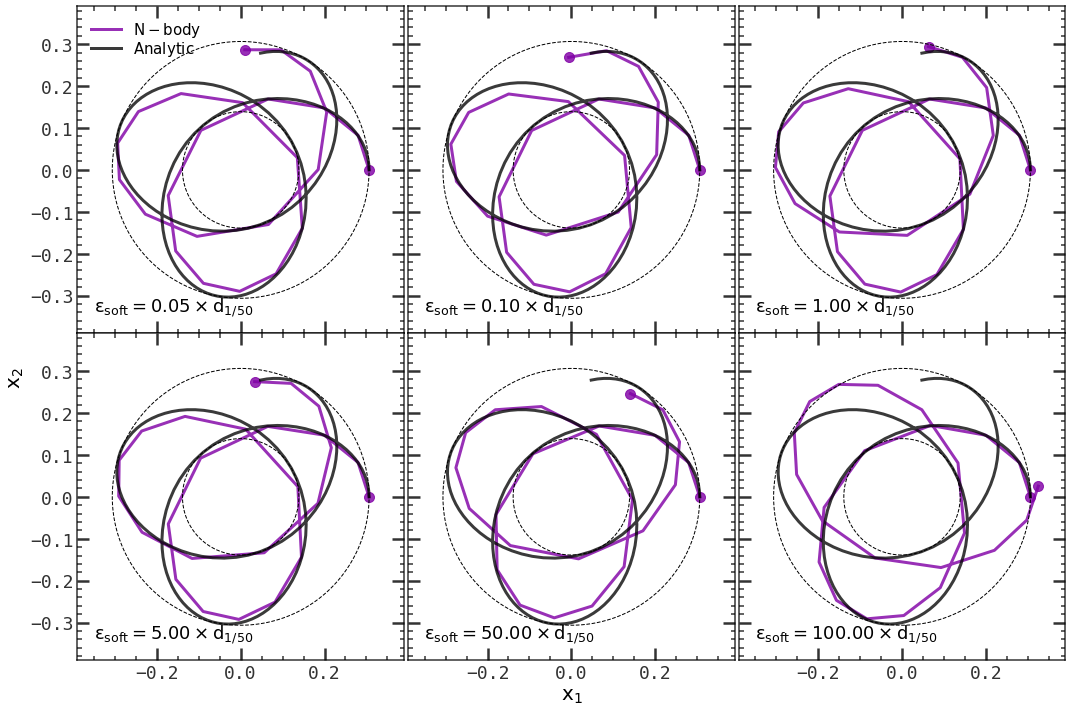

In [173]:
fig, axs = plt.subplots(2,3,figsize=(15,10), sharex = True, sharey=True, gridspec_kw={'hspace':0., 'wspace':0.} )
axs = axs.flat
pid = 0
t_lim = 2.5

x_lim = .39
for axid, j in enumerate([0, 1, 4, 6, 8, 9]):
    op = op_sim_softs[j][pid]
    soft = softs[j]
    ax = axs[axid]
        
    x,y = op.pos[:, :2].T
    t = op.t
    sel = t < t_lim
    ax.plot(x[sel], y[sel], c=mycms2[2], lw=3., label=r'$\rm N-body$' )
    ax.scatter(x[sel][[0,-1]], y[sel][[0,-1]], color=mycms2[2], s=100)
    
    op = op_real[pid]
    x,y = op.pos[::200, :2].T
    t = op.t[::200]
    sel = t < t_lim
    ax.plot(x[sel], y[sel], c=mycms2[-1], lw=3., label=r'$\rm Analytic$')

    r_in, r_out = nfw.r_at_M( m_encs[pid] )
    phi = np.linspace(0., 2.0*np.pi, 200)
    x,y = r_in*np.cos(phi), r_in*np.sin(phi)
    ax.plot(x, y, c='k', ls='--', lw=1.)
    x,y = r_out*np.cos(phi), r_out*np.sin(phi)
    ax.plot(x, y, c='k', ls='--', lw=1.)

    ax.set_aspect('equal')
    m_set_lim(ax, [-x_lim, x_lim], [-x_lim, x_lim])

    txpos(ax, r'$\rm \epsilon_{soft}=%.2f\times d_{1/50}$'%( soft ), (.05, .08), 'k', 18)

axs[0].legend(loc='upper left', frameon=False, fontsize=15, labelspacing=0)
m_set_label(axs[3], y= ' '*20 + r'$\rm x_2$')
m_set_label(axs[4], r'$\rm x_1$')

plt.tight_layout()
plt.savefig('../figs/chg_soft_orbit.pdf')
plt.savefig('../figs/chg_soft_orbit.png')
plt.show()

In [174]:
pid = 0
sel = op_real[pid].t < op_sim_softs[0][0].t.max()
kdt = KDTree( np.hstack([op_real[pid].pos[sel], op_real[pid].vel[sel]]) )
Tr = orbits[pid]['Tr']

dEs = []
dEs_e = []
dLs = []
dLs_e = []
drs = []
drs_e = []

for j in range(len(op_sim_softs)):
    
    op = op_sim_softs[j][pid]
    
    E = op['E']
    dE = np.abs((E-E[0])/E[0])
    dEs.append(dE.mean())
    dEs_e.append(dE.std())
    
    L = op['L_norm']
    dL = np.abs((L-L[0])/L[0])
    dLs.append(dL.mean())
    dLs_e.append(dL.std())
    
    dr = kdt.query( np.hstack([op.pos, op.vel]), k=1, return_distance=True )[0][:, 0]
    drs.append(dr.mean())
    drs_e.append(dr.std())

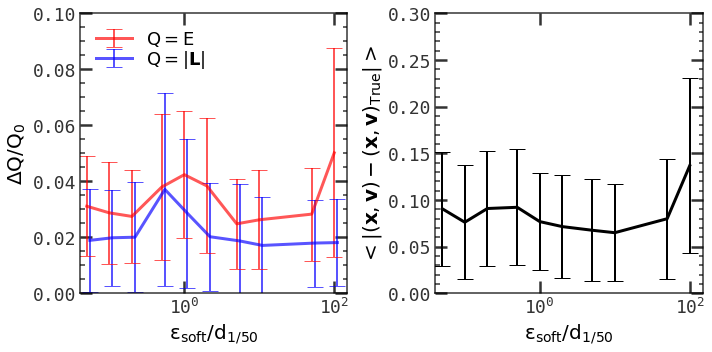

In [175]:
_, axs = m_get_figure( (10, 5), 1, 2 )
axs = axs[0]


efmt = dict( elinewidth=2.0, capthick=1., capsize=8. )

ax = axs[0]
ax.errorbar( softs, dEs, yerr=dEs_e, **efmt, c=mycms2[0], label=r'$\rm Q=E$' )
ax.errorbar( np.array(softs)*1.1, dLs, yerr=dLs_e, **efmt, c=mycms2[1], label=r'$\rm Q=|{\bf L}|$' )
m_set_lim(ax, [0.04, 150], [0., 0.1])
m_set_scale( ax, 'log' )
m_set_label( ax, r'$\rm \epsilon_{soft}/d_{1/50}$', r'$\rm \Delta Q/Q_0$' )
ax.legend( loc='upper left', frameon=False, fontsize=18, labelspacing=0. )

ax = axs[1]
ax.errorbar( softs, drs, yerr=drs_e, **efmt, c='k' )
m_set_label( ax, r'$\rm \epsilon_{soft}/d_{1/50}$', r'$\rm <|({\bf x}, {\bf v}) - ({\bf x}, {\bf v})_{True}|>$' )
m_set_scale( ax, 'log')
m_set_lim(ax, [0.04, 150], [0., 0.3])

plt.tight_layout()
plt.savefig('../figs/chg_soft_stats.pdf')
plt.savefig('../figs/chg_soft_stats.png')
plt.show()

## Change Opening

In [176]:
alphas = [ 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0 ]
ol_sim_alphas = []
for alpha in alphas:
    ol = OrbitLoader('chg_openAng/alpha%.4f/output/snapshot'%alpha, 33, 6)
    ol_sim_alphas.append( ol )

In [177]:
op_sim_alphas = [ [ OrbitPostproc( ol['ts'], ol['xs'][ip], ol['vs'][ip], ol['Vs'][ip] ) 
            for ip in range(6) ] for ol in ol_sim_alphas ]
op_sim_alphas = np.array(op_sim_alphas)

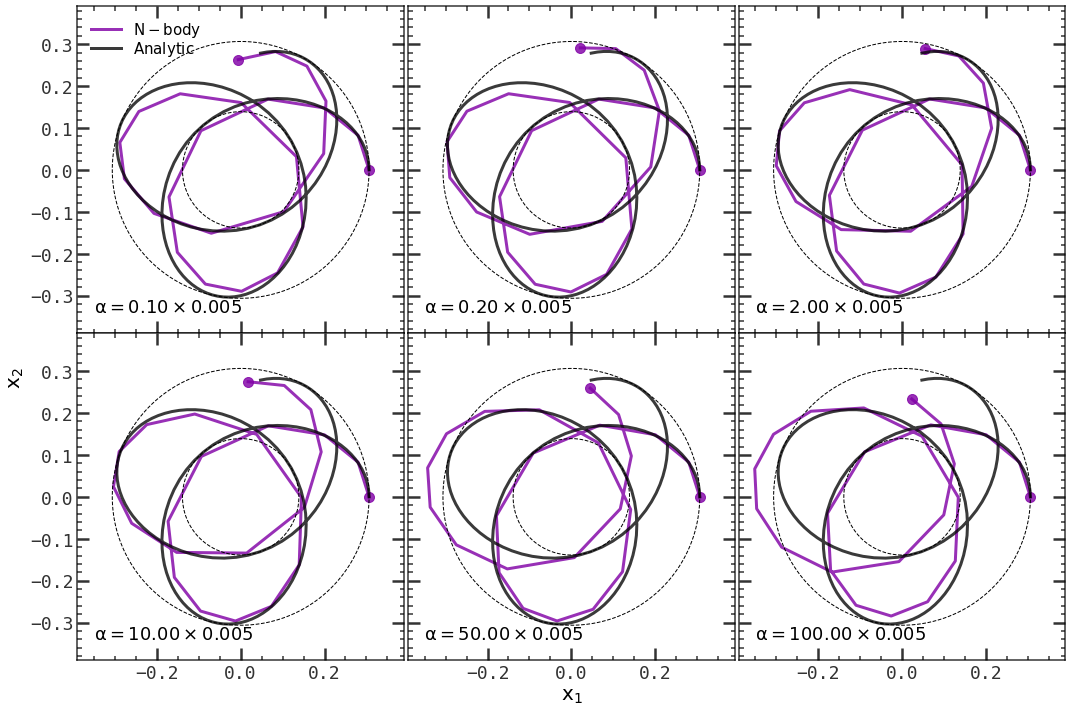

In [178]:
fig, axs = plt.subplots(2,3,figsize=(15,10), sharex = True, sharey=True, gridspec_kw={'hspace':0., 'wspace':0.} )
axs = axs.flat
pid = 0
t_lim = 2.5

x_lim = .39
for axid, j in enumerate([0, 1, 4, 6, 8, 9]):
    op = op_sim_alphas[j][pid]
    alpha = alphas[j]
    ax = axs[axid]
        
    x,y = op.pos[:, :2].T
    t = op.t
    sel = t < t_lim
    ax.plot(x[sel], y[sel], c=mycms2[2], lw=3., label=r'$\rm N-body$' )
    ax.scatter(x[sel][[0,-1]], y[sel][[0,-1]], color=mycms2[2], s=100)
    
    op = op_real[pid]
    x,y = op.pos[::200, :2].T
    t = op.t[::200]
    sel = t < t_lim
    ax.plot(x[sel], y[sel], c=mycms2[-1], lw=3., label=r'$\rm Analytic$')

    r_in, r_out = nfw.r_at_M( m_encs[pid] )
    phi = np.linspace(0., 2.0*np.pi, 200)
    x,y = r_in*np.cos(phi), r_in*np.sin(phi)
    ax.plot(x, y, c='k', ls='--', lw=1.)
    x,y = r_out*np.cos(phi), r_out*np.sin(phi)
    ax.plot(x, y, c='k', ls='--', lw=1.)

    ax.set_aspect('equal')
    m_set_lim(ax, [-x_lim, x_lim], [-x_lim, x_lim])

    txpos(ax, r'$\rm \alpha=%.2f\times 0.005$'%( alpha ), (.05, .08), 'k', 18)

axs[0].legend(loc='upper left', frameon=False, fontsize=15, labelspacing=0)
m_set_label(axs[3], y= ' '*20 + r'$\rm x_2$')
m_set_label(axs[4], r'$\rm x_1$')

plt.tight_layout()
plt.savefig('../figs/chg_alpha_orbit.pdf')
plt.savefig('../figs/chg_alpha_orbit.png')
plt.show()

In [147]:
pid = 0
sel = op_real[pid].t < op_sim_alphas[0][0].t.max()
kdt = KDTree( np.hstack([op_real[pid].pos[sel], op_real[pid].vel[sel]]) )
Tr = orbits[pid]['Tr']

dEs = []
dEs_e = []
dLs = []
dLs_e = []
drs = []
drs_e = []

for j in range(len(op_sim_alphas)):
    
    op = op_sim_alphas[j][pid]
    
    E = op['E']
    dE = np.abs((E-E[0])/E[0])
    dEs.append(dE.mean())
    dEs_e.append(dE.std())
    
    L = op['L_norm']
    dL = np.abs((L-L[0])/L[0])
    dLs.append(dL.mean())
    dLs_e.append(dL.std())
    
    dr = kdt.query( np.hstack([op.pos, op.vel]), k=1, return_distance=True )[0][:, 0]
    drs.append(dr.mean())
    drs_e.append(dr.std())

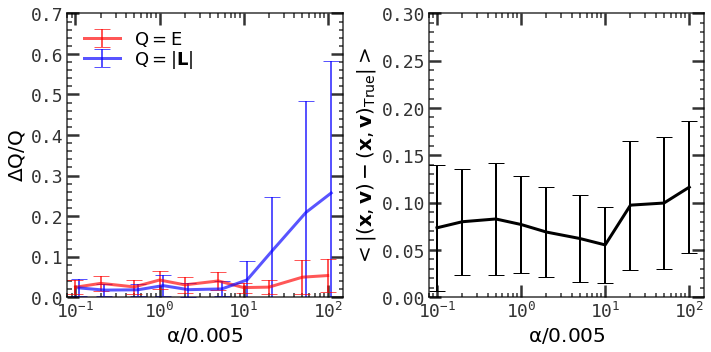

In [143]:
_, axs = m_get_figure( (10, 5), 1, 2 )
axs = axs[0]

efmt = dict( elinewidth=2.0, capthick=1., capsize=8. )

ax = axs[0]
ax.errorbar( alphas, dEs, yerr=dEs_e, **efmt, c=mycms2[0], label=r'$\rm Q=E$' )
ax.errorbar( np.array(alphas)*1.1, dLs, yerr=dLs_e, **efmt, c=mycms2[1], label=r'$\rm Q=|{\bf L}|$' )
m_set_lim(ax, [0.08, 150], [0., 0.7])
m_set_scale( ax, 'log' )
m_set_label( ax, r'$\rm  \alpha/0.005$', r'$\rm \Delta Q/Q$' )
ax.legend( loc='upper left', frameon=False, fontsize=18, labelspacing=0. )

ax = axs[1]
ax.errorbar( alphas, drs, yerr=drs_e, **efmt, c='k' )
m_set_label( ax, r'$\rm \alpha/0.005$', r'$\rm <|({\bf x}, {\bf v}) - ({\bf x}, {\bf v})_{True}|>$' )
m_set_scale( ax, 'log')
m_set_lim(ax, [0.08, 150], [0., 0.3])

plt.tight_layout()
plt.savefig('../figs/chg_alpha_stats.pdf')
plt.savefig('../figs/chg_alpha_stats.png')
plt.show()